# Mustererkennung/Machine Learning - Assignment 6 Solution



In [145]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from math import floor
from collections import Counter

In [10]:
data = np.array(pd.read_csv('/content/drive/MyDrive/ML_Class_2020/Bagging Trees/spambase.data', header=None))

X = data[:,:-1] # features
y = data[:,-1] # Last column is label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True, stratify=y)

print(X_train[0])

[ 0.     0.     0.     0.     6.25   0.     3.12   0.     0.     0.
  0.     3.12   0.     0.     0.     0.     0.     0.     6.25   0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     9.428 60.    66.   ]


In [32]:
# In this approach we binarize the data
# This makes the code simpler but the classification a little worse (probably) 
# So all of our split point z are 0.5 and it only matters at which feature we split


# We take the averages of the positive class and the negative class of the training set
averages_pos = np.mean(X_train[y_train==1], axis=0)
averages_neg = np.mean(X_train[y_train==0], axis=0)

average_of_averages = (averages_pos + averages_neg)/2 
# Due to class imbalance, this is not the same as just taking the average of the full training set
# Define 1 for above average and 0 for below average

X_train_avg = X_train > average_of_averages
X_test_avg = X_test > average_of_averages

class Classifier:
  
    def accuracy(self, labels, predictions):
        return np.mean(labels == predictions)
    
    def confusion_matrix(self, labels, predictions):
        size = len(set(labels))
        matrix = np.zeros((size, size))
        for correct, predicted in zip(labels.astype(int), predictions.astype(int)):
            matrix[correct][predicted] += 1
        return matrix


In [178]:
class DecisionTree(Classifier):

    def fit(self, X, y, max_depth):
        self.num_features = len(X.T)

        # keep track of loss reduction for each feature
        self.feature_importance = np.zeros(self.num_features)  
        self.size_tree = 2**max_depth - 1
        self.size_array_for_tree = 2**(max_depth+1) - 1

        # feature_tree consist of the node_id's (along which dimension we split; this will always be z = 0.5)
        self.feature_tree = np.ones((self.size_array_for_tree), dtype=int) * (-1) 

        # prob_tree labels the data point when we reach a leaf tree
        # if probability >0.5 in that leaf we assign 1 and the other way around
        self.prob_tree = np.ones((self.size_array_for_tree*2)) * (-1)
        self.split_nodes(X, y, 0, 0)
        return self.feature_tree, self.prob_tree
    
    def predict(self, feature_tree, prob_tree, X):
        predictions = []
        for x in X:
            array_position = 0
            node = feature_tree[array_position]
            while feature_tree[self.left(array_position)] != -1 or feature_tree[self.right(array_position)] != -1:
                if x[node]:
                    array_position = self.right(array_position)
                else:
                    array_position = self.left(array_position)
                prediction = prob_tree[array_position]
                node = feature_tree[array_position]
            predictions += [prediction]
        return predictions
    
    def split_nodes(self, X, y, entropy, node_id):
        
        if node_id >= self.size_tree: # Abort if parent node is a leaf
            return
        if len(X) == 1:
            return
        expected_entropies = np.ones(self.num_features) * np.inf # initialize to inf to find true min later
        probs_left = np.empty(self.num_features)
        probs_right = np.empty(self.num_features)
        
        for i, feature in enumerate(X.T):
            if np.sum(X[feature]) == 0 or np.sum(X[np.invert(feature)]) == 0:
                # If one child would get all data points, we don't want to split that way
                continue 
            e_l, e_r, prob_left, prob_right = self.weighted_children_entropy(feature, y)
            e_h = e_l + e_r
            expected_entropies[i] = e_h
            probs_left[i] = prob_left
            probs_right[i] = prob_right
            
        min_e_h = np.argmin(expected_entropies)
        
        # assign importance to feature that was chosen
        if not np.isinf(np.min(expected_entropies)):
            self.feature_importance[min_e_h] += np.abs(entropy - np.min(expected_entropies))

        right = X[:,min_e_h]
        left = np.invert(right)
        


        self.feature_tree[node_id] = min_e_h
        self.prob_tree[self.left(node_id)] = probs_left[min_e_h]
        self.prob_tree[self.right(node_id)] = probs_right[min_e_h]
        
        if len(y[right]) == 0 or len(y[left]) == 0:
            return
        # recursive calls
        self.split_nodes(X[left], y[left], e_l, self.left(node_id))
        self.split_nodes(X[right], y[right], e_r, self.right(node_id))
        
    def entropy(self, p):
        if p == 1.0 or p == 0.0: 
            # The entropy is zero if one event is certain
            return 0
        return - (p * np.log(p) + (1-p) * np.log((1-p)))
    
    def weighted_children_entropy(self, feature, y):
        num_datapoints = len(feature)
        weight_right =  (feature == True).sum()/num_datapoints
        weight_left = 1 - weight_right
        p = np.sum(y[feature])/len(y[feature]) 
        q = np.sum(y[np.invert(feature)])/len(y[np.invert(feature)])
        entropy_right = weight_right * self.entropy(p)
        entropy_left = weight_left * self.entropy(q)
        return entropy_right, entropy_left, q, p
    
    def left(self, node_id):
        return 2 * node_id + 1
    
    def right(self, node_id):
        return 2 * node_id + 2
    
    def parent(self, node_id):
        return floor((node_id - 1)/2)

In [179]:
decision_tree = DecisionTree()

In [180]:
feature_tree, prob_tree = decision_tree.fit(X_train_avg, y_train, 7)

In [181]:
predictions = decision_tree.predict(feature_tree, prob_tree, X_test_avg)
estimates = (np.array(predictions) > 0.5)

In [182]:
decision_tree.accuracy(y_test, estimates)

0.9052997393570807

In [183]:
decision_tree.confusion_matrix(y_test, estimates).astype(int)

array([[668,  29],
       [ 80, 374]])

Assume that classifying a genuine E-Mail as spam is ten times worse than classifying spam as genuine. How would you change the design of your decision tree?


When you check the splits multiply the loss on the side that would classify 0 times 10:

In this case:

In [ ]:
#Pseudo code:
"""

if p > 0.5:
  entropy_left *= 10
if q > 0.5:
  entropy_right *= 10

"""

**Feature Importance:**

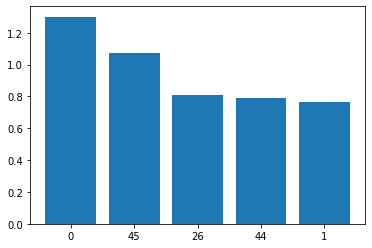

In [184]:
importance_array = np.argsort(-decision_tree.feature_importance)
fig, ax = plt.subplots()
ax.bar(range(5), decision_tree.feature_importance[importance_array[:5]])
ax.set_xticklabels(np.append(0,importance_array[:5]))
plt.show()

In [185]:
class RandomForest(Classifier):
    
    def __init__(self):
        decision_tree = DecisionTree()
    
    def fit(self, X, y, num_trees, num_samples_per_tree, depth):
        self.X = X
        self.y = y
        num_samples = len(X)
        num_features = len(X.T)
        feature_trees = []
        prob_trees = []
        features = []
        for i in range(num_trees):
            random_samples = np.random.randint(0, high=num_samples, size=num_samples_per_tree)
            X = self.X[random_samples]
            y = self.y[random_samples]
            random_features = np.random.randint(0, high=num_features, size=depth*2)
            X = X[:,random_features]
            feature_tree, prob_tree = decision_tree.fit(X, y, depth)
            feature_trees += [feature_tree]
            prob_trees += [prob_tree]
            features += [random_features]
        return feature_trees, prob_trees, features
    
    def predict(self, feature_trees, prob_trees, X):
        predictions = np.empty((len(feature_trees), len(X)))
        for i, (feature_tree, prob_tree, feature_set) in enumerate(zip(feature_trees, prob_trees, features)):
            predictions[i] = decision_tree.predict(feature_tree, prob_tree, X[:,feature_set])
        averaged_predictions = np.mean(predictions, axis=0)
        return averaged_predictions

In [186]:
random_forest = RandomForest()
feature_trees, prob_trees, features = random_forest.fit(X_train_avg, y_train, 50, 1000, 8)

In [187]:
predictions = random_forest.predict(feature_trees, prob_trees, X_test_avg)
estimates = (np.array(predictions) > 0.5)

In [188]:
random_forest.accuracy(y_test, estimates)

0.9270199826238054